TODO
- create aux targets/input from final pitches
- remove at-bats with nulls in pitching inputs

In [1]:
# Network/data is small enough that running on GPU slows training down
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = ''

https://baseballsavant.mlb.com/csv-docs

https://fivethirtyeight.com/features/mlbs-hit-tracking-tool-misses-a-lot-of-hits/

- Player ID map
https://www.smartfantasybaseball.com/tools/

- stats
http://www.seanlahman.com/baseball-archive/statistics/

# Load statcast data

In [2]:
import pandas as pd

try:
    df = pd.read_csv('./statcast-2019-04-10.csv')
except Exception:
    df = pd.read_csv('./statcast-2019-05-18.csv')
df.shape

/home/dante/venvs/python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(698334, 90)

In [3]:
df = df[df.game_year == 2018]
df.shape

(572572, 90)

In [4]:
with pd.option_context('display.max_columns', None):
    display(df.head())

,at_bat_number,away_score,away_team,ax,ay,az,babip_value,balls,bat_score,batter,bb_type,break_angle_deprecated,break_length_deprecated,des,description,effective_speed,error,estimated_ba_using_speedangle,estimated_woba_using_speedangle,events,fielder_2,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,fld_score,game_date,game_pk,game_type,game_year,hc_x,hc_y,hit_distance_sc,hit_location,home_score,home_team,if_fielding_alignment,inning,inning_topbot,iso_value,launch_angle,launch_speed,launch_speed_angle,of_fielding_alignment,on_1b,on_2b,on_3b,outs_when_up,p_throws,pfx_x,pfx_z,pitch_name,pitch_number,pitch_type,pitcher,pitcher.1,plate_x,plate_z,player_name,post_away_score,post_bat_score,post_fld_score,post_home_score,release_extension,release_pos_x,release_pos_y,release_pos_z,release_speed,release_spin_rate,spin_dir,spin_rate_deprecated,stand,strikes,sv_id,sz_bot,sz_top,tfs_deprecated,tfs_zulu_deprecated,type,umpire,vx0,vy0,vz0,woba_denom,woba_value,zone
0,94.0,5.0,LAA,-11.3601,25.1390,-31.7129,1.0,2.0,5.0,543760.0,line_drive,NaN,NaN,Marcus Semien singles on a line drive to right...,hit_into_play_score,82.497,NaN,0.213,0.207,single,455117.0,455117.0,527043.0,446359.0,472528.0,592743.0,457708.0,545361.0,594777.0,5.0,2018-03-29,529412.0,R,2018.0,133.98,82.73,278.0,9.0,5.0,OAK,Strategic,11.0,Bot,0.0,25.0,82.1,3.0,Strategic,459964.0,NaN,621471.0,1.0,R,-0.9585,0.0858,Changeup,6.0,CH,598287.0,598287.0,1.0147,2.5574,Noe Ramirez,5.0,5.0,5.0,5.0,5.991,-2.6238,54.5068,5.0668,83.5,2202.0,NaN,NaN,R,2.0,180330_000927,1.3048,3.0286,NaN,NaN,X,NaN,10.1373,-121.0093,0.5756,1.0,0.9,12.0
1,94.0,5.0,LAA,-10.9769,23.0148,-32.6285,NaN,2.0,5.0,543760.0,NaN,NaN,NaN,NaN,foul,82.405,NaN,NaN,NaN,NaN,455117.0,455117.0,527043.0,446359.0,472528.0,592743.0,457708.0,545361.0,594777.0,5.0,2018-03-29,529412.0,R,2018.0,NaN,NaN,9.0,NaN,5.0,OAK,Strategic,11.0,Bot,NaN,-17.0,75.1,NaN,Strategic,459964.0,NaN,621471.0,1.0,R,-0.9663,0.0005,Changeup,5.0,CH,598287.0,598287.0,0.4161,2.7585,Noe Ramirez,5.0,5.0,5.0,5.0,6.174,-2.6167,54.3240,5.0671,82.7,2035.0,NaN,NaN,R,2.0,180330_000833,1.3010,3.0452,NaN,NaN,S,NaN,8.7471,-120.1073,1.2442,NaN,NaN,3.0
2,94.0,5.0,LAA,7.1848,23.4589,-32.9895,NaN,2.0,5.0,543760.0,NaN,NaN,NaN,NaN,foul,75.252,NaN,NaN,NaN,NaN,455117.0,455117.0,527043.0,446359.0,472528.0,592743.0,457708.0,545361.0,594777.0,5.0,2018-03-29,529412.0,R,2018.0,NaN,NaN,254.0,NaN,5.0,OAK,Strategic,11.0,Bot,NaN,27.0,80.3,NaN,Strategic,459964.0,NaN,621471.0,1.0,R,0.9971,-0.0254,Curveball,4.0,CU,598287.0,598287.0,-0.1869,2.1676,Noe Ramirez,5.0,5.0,5.0,5.0,5.360,-2.9329,55.1378,4.8254,77.2,2875.0,NaN,NaN,R,1.0,180330_000804,1.3010,3.0452,NaN,NaN,S,NaN,4.0109,-112.0582,1.4503,NaN,NaN,5.0
3,94.0,5.0,LAA,2.7950,23.1420,-33.8923,NaN,2.0,5.0,543760.0,NaN,NaN,NaN,NaN,foul,74.808,NaN,NaN,NaN,NaN,455117.0,455117.0,527043.0,446359.0,472528.0,592743.0,457708.0,545361.0,594777.0,5.0,2018-03-29,529412.0,R,2018.0,NaN,NaN,NaN,NaN,5.0,OAK,Strategic,11.0,Bot,NaN,NaN,NaN,NaN,Strategic,459964.0,NaN,621471.0,1.0,R,0.5234,-0.1545,Curveball,3.0,CU,598287.0,598287.0,0.7067,1.7718,Noe Ramirez,5.0,5.0,5.0,5.0,5.545,-2.8895,54.9534,4.8506,76.6,2722.0,NaN,NaN,R,0.0,180330_000729,1.3010,3.0452,NaN,NaN,S,NaN,6.5573,-111.0574,0.9231,NaN,NaN,9.0
4,94.0,5.0,LAA,6.9345,23.0959,-31.9858,NaN,1.0,5.0,543760.0,NaN,NaN,NaN,NaN,ball,76.087,NaN,NaN,NaN,NaN,455117.0,455117.0,527043.0,446359.0,472528.0,592743.0,457708.0,545361.0,594777.0,5.0,2018-03-29,529412.0,R,2018.0,NaN,NaN,NaN,NaN,5.0,OAK,Strategic,11.0,Bot,NaN,NaN,NaN,NaN,Strategic,459964.0,NaN,621471.0,1.0,R,1.0697,0.1136,Curveball,2.0,CU,598287.0,598287.0,2.3848,2.7632,Noe Ramirez,5.0,5.0,5.0,5.0,5.563,-2.8185,54.9349,4.8878,77.8,2880.0,NaN,NaN,R,0.0,180330_000704,1.6456,3.4918,NaN,NaN,B,NaN,9.0882,-112.7488,2.2400,NaN,NaN,12.0


In [5]:
with pd.option_context('display.max_columns', None):
    display(df[df.ax.isnull()].head())

,at_bat_number,away_score,away_team,ax,ay,az,babip_value,balls,bat_score,batter,bb_type,break_angle_deprecated,break_length_deprecated,des,description,effective_speed,error,estimated_ba_using_speedangle,estimated_woba_using_speedangle,events,fielder_2,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,fld_score,game_date,game_pk,game_type,game_year,hc_x,hc_y,hit_distance_sc,hit_location,home_score,home_team,if_fielding_alignment,inning,inning_topbot,iso_value,launch_angle,launch_speed,launch_speed_angle,of_fielding_alignment,on_1b,on_2b,on_3b,outs_when_up,p_throws,pfx_x,pfx_z,pitch_name,pitch_number,pitch_type,pitcher,pitcher.1,plate_x,plate_z,player_name,post_away_score,post_bat_score,post_fld_score,post_home_score,release_extension,release_pos_x,release_pos_y,release_pos_z,release_speed,release_spin_rate,spin_dir,spin_rate_deprecated,stand,strikes,sv_id,sz_bot,sz_top,tfs_deprecated,tfs_zulu_deprecated,type,umpire,vx0,vy0,vz0,woba_denom,woba_value,zone
161,79.0,2.0,MIN,NaN,NaN,NaN,NaN,0.0,2.0,592696.0,NaN,NaN,NaN,NaN,missed_bunt,NaN,NaN,NaN,NaN,NaN,543376.0,543376.0,448801.0,570731.0,542921.0,592518.0,641820.0,430945.0,458675.0,2.0,2018-03-29,529414.0,R,2018.0,NaN,NaN,NaN,NaN,2.0,BAL,Infield shift,11.0,Top,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,0.0,L,NaN,NaN,NaN,2.0,NaN,542947.0,542947.0,NaN,NaN,Richard Bleier,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L,1.0,180329_223046,1.3131,3.0208,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN
400,73.0,5.0,LAA,NaN,NaN,NaN,NaN,1.0,5.0,446359.0,NaN,NaN,NaN,NaN,ball,NaN,NaN,NaN,NaN,NaN,518960.0,518960.0,621566.0,476704.0,656305.0,543760.0,459964.0,621471.0,572039.0,5.0,2018-03-29,529412.0,R,2018.0,NaN,NaN,NaN,NaN,5.0,OAK,Standard,9.0,Top,NaN,NaN,NaN,NaN,Standard,455117.0,NaN,NaN,2.0,R,NaN,NaN,NaN,2.0,NaN,595014.0,595014.0,NaN,NaN,Blake Treinen,5.0,5.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,0.0,180329_231427,1.6256,3.4754,NaN,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN
479,65.0,5.0,NYY,NaN,NaN,NaN,NaN,2.0,1.0,518626.0,NaN,NaN,NaN,NaN,swinging_strike,97.637,NaN,NaN,NaN,NaN,596142.0,596142.0,435522.0,642180.0,592273.0,544369.0,458731.0,543305.0,592450.0,5.0,2018-03-29,529415.0,R,2018.0,NaN,NaN,NaN,NaN,1.0,TOR,Infield shift,8.0,Bot,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,2.0,R,NaN,NaN,4-Seam Fastball,3.0,FF,476454.0,476454.0,NaN,NaN,Dellin Betances,5.0,1.0,5.0,1.0,6.467,NaN,NaN,NaN,97.2,2299.0,NaN,NaN,R,0.0,180329_225329,1.6244,3.5044,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN
678,67.0,1.0,MIL,NaN,NaN,NaN,0.0,1.0,0.0,452104.0,fly_ball,NaN,NaN,Chase Headley flies out to right fielder Domin...,hit_into_play,97.155,NaN,0.047,0.062,field_out,444489.0,444489.0,460075.0,519299.0,543768.0,606115.0,592885.0,456715.0,570267.0,1.0,2018-03-29,529413.0,R,2018.0,186.43,77.92,325.0,9.0,0.0,SD,Standard,9.0,Bot,0.0,31.0,86.5,3.0,Standard,641319.0,NaN,NaN,1.0,R,NaN,NaN,4-Seam Fastball,2.0,FF,608349.0,608349.0,NaN,NaN,Corey Knebel,1.0,0.0,1.0,0.0,6.438,NaN,NaN,NaN,97.4,2584.0,NaN,NaN,L,0.0,180329_224527,1.3430,3.1214,NaN,NaN,X,NaN,NaN,NaN,NaN,1.0,0.0,NaN
1310,54.0,3.0,HOU,NaN,NaN,NaN,NaN,0.0,0.0,596059.0,NaN,NaN,NaN,NaN,foul,93.457,NaN,NaN,NaN,NaN,435263.0,435263.0,503556.0,514888.0,608324.0,621043.0,502210.0,545350.0,543807.0,3.0,2018-03-29,529411.0,R,2018.0,NaN,NaN,214.0,NaN,0.0,TEX,Infield shift,7.0,Bot,NaN,NaN,NaN,NaN,Strategic,NaN,NaN,NaN,2.0,R,NaN,NaN,4-Seam Fastball,1.0,FF,606965.0,606965.0,NaN,NaN,Chris Devenski,3.0,0.0,3.0,0.0,5.208,NaN,NaN,NaN,95.5,2326.0,NaN,NaN,L,0.0,180329_215455,1.1655,2.9233,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# df = df[df.type.ne('B')]
df = df[~df.game_pk.isnull()]
df.shape

(572572, 90)

## Remove at-bats due to fielding influence

In [7]:
invalid_events = {
    'catcher_interf',
    'fielders_choice_out',
    'field_error',
    'fielders_choice',
    'batter_interference',
}
invalid_at_bats = df.loc[:, ['game_pk', 'at_bat_number', 'events']]
invalid_at_bats['remove'] = invalid_at_bats.events.isin(invalid_events)
invalid_at_bats = invalid_at_bats.groupby(['game_pk', 'at_bat_number']).remove.max()

In [8]:
invalid_at_bats.sum()

1628

In [9]:
invalid_at_bats = pd.DataFrame(invalid_at_bats[~invalid_at_bats])
df = df.merge(invalid_at_bats, left_on=invalid_at_bats.index.names, right_index=True)
df.shape

(566962, 91)

## Remove at-bats with missing data

In [10]:
# df = df[~(df.ax.isnull() | df.az.isnull() | df.ay.isnull())]
# df.shape

# Load player IDs

In [11]:
player_ids = pd.read_excel('~/Downloads/SFBB-Player-ID-Map.xlsx')
player_ids.shape

(2177, 42)

In [12]:
with pd.option_context('display.max_columns', None):
    display(player_ids.head())

,IDPLAYER,PLAYERNAME,BIRTHDATE,FIRSTNAME,LASTNAME,TEAM,LG,POS,IDFANGRAPHS,FANGRAPHSNAME,MLBID,MLBNAME,CBSID,CBSNAME,RETROID,BREFID,NFBCID,NFBCNAME,ESPNID,ESPNNAME,KFFLNAME,DAVENPORTID,BPID,YAHOOID,YAHOONAME,MSTRBLLNAME,BATS,THROWS,FANTPROSNAME,LASTCOMMAFIRST,ROTOWIREID,FANDUELNAME,FANDUELID,DRAFTKINGSNAME,OTTONEUID,HQID,RAZZBALLNAME,FANTRAXID,FANTRAXNAME,ROTOWIRENAME,ALLPOS,NFBCLASTFIRST
0,aardsda01,David Aardsma,1981-12-27,David,Aardsma,NaN,NaN,P,1902,David Aardsma,430911.0,David Aardsma,479025.0,David Aardsma,aardd001,aardsda01,7307.0,David Aardsma,5933.0,David Aardsma,NaN,AARDSMA19811227A,45369.0,7307.0,David Aardsma,"Aardsma, David",R,R,David Aardsma,"Aardsma, David",7633.0,NaN,NaN,David Aardsma,4362.0,NaN,David Aardsma,NaN,NaN,David Aardsma,P,"Aardsma, David"
1,abadfe01,Fernando Abad,1985-12-17,Fernando,Abad,NaN,NaN,P,4994,Fernando Abad,472551.0,Fernando Abad,1723564.0,Fernando Abad,abadf001,abadfe01,8767.0,Fernando Abad,30417.0,Fernando Abad,NaN,ABAD19851217A,49706.0,8767.0,Fernando Abad,"Abad, Fernando",L,L,Fernando Abad,"Abad, Fernando",11285.0,Fernando Abad,12453.0,Fernando Abad,7372.0,3556.0,Fernando Abad,01viz,"Abad, Fernando",Fernando Abad,P,"Abad, Fernando"
2,abreual01,Albert Abreu,1995-09-26,Albert,Abreu,NYY,AL,P,sa828366,Albert Abreu,656061.0,Albert Abreu,2211792.0,Albert Abreu,NaN,abreual01,10546.0,Albert Abreu,36041.0,NaN,NaN,NaN,104651.0,NaN,NaN,"Abreu, Albert",R,R,Albert Abreu,"Abreu, Albert",14063.0,NaN,NaN,NaN,NaN,5762.0,Albert Abreu,NaN,NaN,Albert Abreu,P,"Abreu, Albert"
3,abreubo01,Bobby Abreu,1974-03-11,Bobby,Abreu,NaN,NaN,OF,945,Bobby Abreu,110029.0,Bobby Abreu,7367.0,Bobby Abreu,abreb001,abreubo01,5698.0,Bobby Abreu,3537.0,Bobby Abreu,Bobby Abreu,ABREU19740311A,650.0,5698.0,Bobby Abreu,"Abreu, Bobby",L,R,Bobby Abreu,"Abreu, Bobby",NaN,NaN,NaN,NaN,8984.0,NaN,Bobby Abreu,NaN,NaN,NaN,OF,"Abreu, Bobby"
4,abreujo02,Jose Abreu,1987-01-29,Jose,Abreu,CHW,AL,1B,15676,Jose Abreu,547989.0,Jose Abreu,2106364.0,Jose Abreu,abrej003,abreujo02,9540.0,Jose Abreu,33095.0,Jose Abreu,Jose Abreu,ABREUcubaJ01,102005.0,9540.0,Jose Abreu,"Abreu, Jose",R,R,Jose Abreu,"Abreu, Jose",11341.0,Jose Abreu,49523.0,Jose Abreu,18286.0,4515.0,Jose Abreu,02i2e,"Abreu, Jose","Abreu, Jose",1B,"Abreu, Jose"


In [13]:
player_ids = player_ids[['MLBID', 'MLBNAME', 'IDPLAYER']]
batter_ids = player_ids.copy()
batter_ids.columns = [f'batter_{c.lower()}' for c in batter_ids.columns]
pitcher_ids = player_ids.copy()
pitcher_ids.columns = [f'pitcher_{c.lower()}' for c in pitcher_ids.columns]

In [14]:
batter_ids = batter_ids[~batter_ids.batter_mlbid.isnull()]
pitcher_ids = pitcher_ids[~pitcher_ids.pitcher_mlbid.isnull()]

In [15]:
assert len(batter_ids) == batter_ids.batter_mlbid.nunique(), f'{len(batter_ids)} != {batter_ids.batter_mlbid.nunique()}'

In [16]:
assert len(pitcher_ids) == pitcher_ids.pitcher_mlbid.nunique(), f'{len(pitcher_ids)} != {pitcher_ids.pitcher_mlbid.nunique()}'

## Blend IDs in with statcast data

In [17]:
df = df.merge(batter_ids, left_on='batter', right_on='batter_mlbid', how='left')
df = df.merge(pitcher_ids, left_on='pitcher', right_on='pitcher_mlbid', how='left')
df.shape

(566962, 97)

In [18]:
with pd.option_context('display.max_columns', None):
    display(df[df.batter_mlbname.isnull()].sample(20).head())

,at_bat_number,away_score,away_team,ax,ay,az,babip_value,balls,bat_score,batter,bb_type,break_angle_deprecated,break_length_deprecated,des,description,effective_speed,error,estimated_ba_using_speedangle,estimated_woba_using_speedangle,events,fielder_2,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,fld_score,game_date,game_pk,game_type,game_year,hc_x,hc_y,hit_distance_sc,hit_location,home_score,home_team,if_fielding_alignment,inning,inning_topbot,iso_value,launch_angle,launch_speed,launch_speed_angle,of_fielding_alignment,on_1b,on_2b,on_3b,outs_when_up,p_throws,pfx_x,pfx_z,pitch_name,pitch_number,pitch_type,pitcher,pitcher.1,plate_x,plate_z,player_name,post_away_score,post_bat_score,post_fld_score,post_home_score,release_extension,release_pos_x,release_pos_y,release_pos_z,release_speed,release_spin_rate,spin_dir,spin_rate_deprecated,stand,strikes,sv_id,sz_bot,sz_top,tfs_deprecated,tfs_zulu_deprecated,type,umpire,vx0,vy0,vz0,woba_denom,woba_value,zone,remove,batter_mlbid,batter_mlbname,batter_idplayer,pitcher_mlbid,pitcher_mlbname,pitcher_idplayer
505603,26.0,1.0,CWS,-21.0462,27.8198,-22.9836,NaN,2.0,7.0,608654.0,NaN,NaN,NaN,NaN,foul,92.242,NaN,NaN,NaN,NaN,553882.0,553882.0,547170.0,660162.0,570560.0,641313.0,594953.0,641477.0,541645.0,1.0,2018-09-29,531810.0,R,2018.0,NaN,NaN,197.0,NaN,7.0,MIN,Standard,2.0,Bot,NaN,24.0,71.5,NaN,Standard,592122.0,NaN,543257.0,2.0,R,-1.5893,0.7248,Sinker,5.0,SI,491646.0,491646.0,0.1088,2.8628,Jeanmar Gomez,1.0,7.0,1.0,7.0,6.730,-2.0835,53.7691,5.7817,91.5,2129.0,NaN,NaN,R,2.0,180930_002053,1.4761,3.0432,NaN,NaN,S,NaN,9.0703,-133.0169,-3.0970,NaN,NaN,2.0,False,NaN,NaN,NaN,491646.0,Jeanmar Gomez,gomezje01
483599,19.0,0.0,KC,7.6069,20.1269,-19.6924,0.0,1.0,0.0,595956.0,fly_ball,NaN,NaN,Cam Gallagher flies out to left fielder Eddie ...,hit_into_play,81.003,NaN,0.005,0.008,field_out,641598.0,641598.0,408045.0,523253.0,501303.0,593871.0,592696.0,595909.0,596146.0,2.0,2018-09-07,531515.0,R,2018.0,92.13,114.64,NaN,7.0,2.0,MIN,Standard,3.0,Top,0.0,39.0,89.2,3.0,Standard,NaN,NaN,NaN,0.0,L,0.6833,1.2884,Changeup,3.0,CH,624427.0,624427.0,-0.0991,2.3790,Stephen Gonsalves,0.0,0.0,2.0,2.0,6.719,2.5875,53.7808,6.0846,80.1,1698.0,NaN,NaN,R,1.0,180908_005226,1.6256,3.4152,NaN,NaN,X,NaN,-7.2976,-116.5655,-4.0189,1.0,0.00,5.0,False,NaN,NaN,NaN,624427.0,Stephen Gonsalves,gonsast01
503115,79.0,4.0,CLE,10.2625,30.9090,-17.2665,0.0,3.0,9.0,650619.0,NaN,NaN,NaN,Meibrys Viloria strikes out swinging.,swinging_strike,91.780,NaN,NaN,NaN,strikeout,547379.0,547379.0,475174.0,608070.0,650490.0,489267.0,434658.0,656185.0,488681.0,4.0,2018-09-29,531811.0,R,2018.0,NaN,NaN,NaN,2.0,9.0,KC,Standard,8.0,Bot,0.0,NaN,NaN,NaN,Standard,571718.0,593528.0,NaN,2.0,L,0.7144,1.2146,4-Seam Fastball,6.0,FF,543272.0,543272.0,0.1677,3.5044,Brad Hand,4.0,9.0,4.0,9.0,5.048,2.5831,55.4517,5.8855,94.2,2293.0,NaN,NaN,L,2.0,180930_021502,1.5130,3.3190,NaN,NaN,S,NaN,-7.5812,-136.6946,-2.9382,1.0,0.00,12.0,False,NaN,NaN,NaN,543272.0,Brad Hand,handbr01
364768,69.0,3.0,LAD,9.2513,27.1498,-20.3015,NaN,1.0,1.0,605244.0,NaN,NaN,NaN,NaN,swinging_strike,92.239,NaN,NaN,NaN,NaN,518735.0,518735.0,571970.0,571771.0,457759.0,592518.0,592626.0,641355.0,624577.0,3.0,2018-09-28,531799.0,R,2018.0,NaN,NaN,NaN,NaN,1.0,SF,Standard,9.0,Bot,NaN,NaN,NaN,NaN,Standard,543063.0,NaN,NaN,1.0,R,0.8302,0.9390,Cutter,3.0,FC,445276.0,445276.0,0.3516,3.1610,Kenley Jansen,3.0,1.0,3.0,1.0,6.839,-1.8111,53.6588,6.1122,91.0,2355.0,NaN,NaN,R,1.0,180929_053426,1.5890,3.4670,NaN,NaN,S,NaN,3.6569,-132.6451,-3.6323,NaN,NaN,3.0,False,NaN,NaN,NaN,445276.0,Kenley Jansen,janseke01
37388,44.0,5.0,PHI,-16.0465,32.7112,-15.2698,1.0,1.0,3.0,608654.0,line_drive,NaN,NaN,Johnny Field doubles (1) on a sharp line drive...,hit_into_play_no_out,96.548,NaN,0.642,0.833,double,595284.0,595284.0,467793.0,664068.0,596748.0,465753.0,656555.0,546318.0,571437.0,5.0,2018-04-15,529636.0,R,2018.0,39.32,78.45,348.0,7.0,3.0,TB,Standard,5.0,Bot,1.0,19.0,104.1,5.0,Standard,NaN,NaN,NaN,2.0,R,

# Load statistics

## Batting

In [19]:
batting_stats = pd.read_csv('baseballdatabank-2019.2/core/Batting.csv')
batting_stats = batting_stats.merge(batter_ids, left_on='playerID', right_on='batter_idplayer')
batting_stats = batting_stats[batting_stats.yearID == 2018]
batting_stats.shape

(1205, 25)

In [20]:
# players are represented multiple times when there is a trade
batting_stats = batting_stats.groupby('batter_mlbid', as_index=False)[[
    'H', 'BB', 'HBP', '2B', '3B', 'HR', 'SF', 'AB'
]].sum()
batting_stats['1B'] = batting_stats.H - (batting_stats['2B'] - batting_stats['3B'] - batting_stats['HR'])
batting_stats.shape

(1071, 10)

In [21]:
stats = batting_stats  # alias
stats['ba'] = stats['H'] / stats['AB']
stats['obp'] = (stats['H'] + stats['BB'] + stats['HBP']) / (stats['AB'] + stats['BB'] + stats['SF'] + stats['HBP'])
stats['slg'] = (stats['1B'] + (2*stats['2B']) + (3*stats['3B']) + (4*stats['HR'])) / stats.AB
stats['ops'] = stats.obp + stats.slg
stats['obp'].describe(), stats.slg.describe(), stats.ops.describe()

(count    823.000000
 mean       0.244371
 std        0.144940
 min        0.000000
 25%        0.161528
 50%        0.285714
 75%        0.330852
 max        1.000000
 Name: obp, dtype: float64, count    823.000000
 mean       0.345414
 std        0.246788
 min        0.000000
 25%        0.125000
 50%        0.388889
 75%        0.504371
 max        2.000000
 Name: slg, dtype: float64, count    823.000000
 mean       0.589784
 std        0.373841
 min        0.000000
 25%        0.312091
 50%        0.684118
 75%        0.835459
 max        3.000000
 Name: ops, dtype: float64)

## Pitching

In [22]:
pitching_stats = pd.read_csv('baseballdatabank-2019.2/core/Pitching.csv')
pitching_stats = pitching_stats[pitching_stats.yearID == 2018]
pitching_stats = pitching_stats.merge(pitcher_ids, left_on='playerID', right_on='pitcher_idplayer')
pitching_stats.shape

(657, 33)

In [23]:
pitching_stats['IP'] = pitching_stats.IPouts / 3

In [24]:
pitching_stats = pitching_stats.groupby([
    'pitcher_mlbid',
], as_index=False)[['IP', 'BB', 'H', 'ER']].sum()
pitching_stats.shape

(581, 5)

In [25]:
pitching_stats['ERA'] = ((pitching_stats.ER / pitching_stats.IP) * 9 )
pitching_stats['WHIP'] = (pitching_stats.BB + pitching_stats.H) / pitching_stats.IP

# Feature engineering

## Create target variable

Did the at-bat result in a hit or walk?

In [26]:
df.events.unique()

array(['single', nan, 'triple', 'strikeout', 'field_out', 'double',
       'walk', 'grounded_into_double_play', 'home_run', 'hit_by_pitch',
       'sac_bunt', 'pickoff_caught_stealing_2b', 'caught_stealing_2b',
       'force_out', 'double_play', 'sac_fly', 'other_out', 'pickoff_1b',
       'strikeout_double_play', 'caught_stealing_3b', 'pickoff_2b',
       'triple_play', 'sac_bunt_double_play', 'caught_stealing_home',
       'sac_fly_double_play', 'pickoff_3b',
       'pickoff_caught_stealing_home', 'pickoff_caught_stealing_3b',
       'run'], dtype=object)

In [27]:
import numpy as np

on_base_events = [
    'single',
    'double',
    'triple',
    'home_run',
    'walk',
]

df['target'] = df.events.isin(on_base_events).astype(int)

## Create auxillary targets

In [28]:
auxillary_targets = [
    'hit_distance_sc',
    'launch_speed',
    'launch_angle',
]
for t in auxillary_targets:
    df[t] = (df[t] - df[t].mean()) / df[t].std()
df['auxillary_targets'] = df[auxillary_targets].fillna(0).values.tolist()

In [29]:
import numpy as np
np.stack(df.iloc[:10]['auxillary_targets'])

array([[ 0.94858298, -0.0637947 ,  0.29688873],
       [-1.26468766, -0.53543634, -1.15239467],
       [ 0.75111645, -0.18507398,  0.36590222],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 1.55743809,  0.5762904 ,  0.19336848],
       [ 0.42200558, -0.62302694,  1.26307766],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

# Who's on first

Or rather, is anyone on first.

In [30]:
df['runner_on_first'] = (~df.on_1b.isnull()).astype(int)
df['runner_on_second'] = (~df.on_2b.isnull()).astype(int)
df['runner_on_third'] = (~df.on_3b.isnull()).astype(int)

In [31]:
total_pitches = df.loc[:, ['game_pk', 'at_bat_number', 'pitch_number', 'pitcher']]
total_pitches['counter'] = 1

# How many pitches has the pitcher thrown

In [32]:
total_pitches.sort_values(['game_pk', 'pitcher', 'at_bat_number', 'pitch_number'], inplace=True)
total_pitches['total_pitch_number'] = total_pitches.groupby([
    'game_pk', 'pitcher'
], as_index=False).counter.cumsum()
with pd.option_context('display.max_rows', None):
    display(total_pitches.head(100))

,game_pk,at_bat_number,pitch_number,pitcher,counter,total_pitch_number
3965,529406.0,1.0,1.0,502042.0,1,1
3944,529406.0,2.0,1.0,502042.0,1,2
3943,529406.0,2.0,2.0,502042.0,1,3
3942,529406.0,2.0,3.0,502042.0,1,4
3843,529406.0,3.0,1.0,502042.0,1,5
3842,529406.0,3.0,2.0,502042.0,1,6
3841,529406.0,3.0,3.0,502042.0,1,7
3840,529406.0,3.0,4.0,502042.0,1,8
3839,529406.0,3.0,5.0,502042.0,1,9
3838,529406.0,3.0,6.0,502042.0,1,10


In [33]:
df = df.merge(total_pitches, on=['game_pk', 'pitcher', 'at_bat_number', 'pitch_number'])

# Create batter IDs to be embedded

In [34]:
import numpy as np
eligible_batters = batting_stats[batting_stats.AB > 100].batter_mlbid
df['batter_id'] = np.where(df.batter.isin(eligible_batters), df.batter, 0)

In [35]:
df[['batter_id', 'batter_mlbname']].drop_duplicates().shape

(820, 2)

## Create pitcher IDs to be embedded

In [36]:
eligible_pitchers = pitching_stats[pitching_stats.IP > 20].pitcher_mlbid
df['pitcher_id'] = np.where(df.pitcher.isin(eligible_pitchers), df.pitcher, 0)
len(eligible_pitchers), df.pitcher_id.nunique()

(451, 452)

# Define features

In [37]:
numeric_features = [
    'bat_score',  # these are pre-pitch
    'fld_score',  # these are pre-pitch
    'balls',
    'strikes',
    'outs_when_up',
#    'pitch_number',
    'inning',
    'total_pitch_number',
    'at_bat_number',
    'ax',
    'ay',
    'az',
    'pfx_x',
    'pfx_z',
    'vx0',
    'vy0',
    'vz0',
    'release_speed',
    'release_spin_rate',
    'release_pos_x',
    'release_pos_y',
    'plate_x',
    'plate_z',
    'sz_top',
    'sz_bot',
]

categorical_features = [
    'if_fielding_alignment',
    'of_fielding_alignment',
    'inning_topbot',  # home field advantage
    'pitch_name',
    'zone',
    'pitcher_id',
    'batter_id',  # mapping of batters with less than 100 AB to 0
    'game_type',
    'stand',  # for batter
    'runner_on_first',
    'runner_on_second',
    'runner_on_third',
    'away_team',
    'home_team',
    'p_throws',
]

target = 'target'

# Linear model

In [38]:
import sklearn

class GetDummies(sklearn.base.TransformerMixin):
    """Fast one-hot-encoder that makes use of pandas.get_dummies() safely
    on train/test splits.
    """
    def __init__(self, dtypes=None):
        self.input_columns = None
        self.final_columns = None
        if dtypes is None:
            dtypes = [object, 'category']
        self.dtypes = dtypes

    def fit(self, X, y=None):
        self.input_columns = list(X.select_dtypes(self.dtypes).columns)
        X = pd.get_dummies(X, columns=self.input_columns)
        self.final_columns = X.columns
        return self
        
    def transform(self, X, y=None):
        X = pd.get_dummies(X, columns=self.input_columns)
        X_columns = X.columns
        # if columns in X had values not in the data set used during
        # fit add them and set to 0
        missing = [c for c in self.final_columns if not c in X_columns]
        for c in missing:
            X[c] = 0
        # remove any new columns that may have resulted from values in
        # X that were not in the data set when fit
        return X[self.final_columns]
    
    def get_feature_names(self):
        return tuple(self.final_columns)


In [39]:
final_pitch = (df
    .sort_values(['game_pk', 'at_bat_number', 'pitch_number'])
    .groupby(['game_pk', 'at_bat_number'])
    .tail(1)
)
X = final_pitch[numeric_features + categorical_features]

y = final_pitch.target.values

In [40]:
y.mean(axis=0)

0.30497813702635973

In [41]:
X.isnull().any(axis=1).mean()

0.022304371215360635

In [42]:
X, y = X[~X.isnull().any(axis=1)], y[~X.isnull().any(axis=1)]

In [43]:
get_dummies = GetDummies()
X_t = X.copy()
for f in categorical_features:
    X_t[f] = X_t[f].astype(str)
X_t = get_dummies.fit_transform(X_t)

In [44]:
X_t.shape

(141760, 1007)

In [45]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
linear_model = Sequential([
    BatchNormalization(),
    Dense(1, activation='sigmoid', name='y', input_dim=X_t.shape[-1])
])
linear_model.compile(loss='binary_crossentropy', optimizer='adam')
linear_model.fit(X_t.values, y, epochs=3)

Using TensorFlow backend.


Epoch 1/3
141760/141760 [==============================] - 13s 94us/step - loss: 0.5845
Epoch 2/3
141760/141760 [==============================] - 13s 91us/step - loss: 0.5765
Epoch 3/3
141760/141760 [==============================] - 13s 90us/step - loss: 0.5763


In [46]:
model_features = get_dummies.get_feature_names()
coefficients = linear_model.get_layer('y').get_weights()[0].reshape(-1)

In [47]:
coefficients

array([ 0.04748153,  0.03554403,  0.36544052, ..., -0.00432711,
       -0.02546483, -0.00886804], dtype=float32)

In [48]:
import json
sorted_coefficients = sorted([(f, c.astype(float)) for f, c in zip(model_features, coefficients)], reverse=True, key=lambda x: abs(x[-1]))
with open('deep-learning-static/linear-coefficients.json', mode='w') as f:
    json.dump(sorted_coefficients, f)
sorted_coefficients

[('balls', 0.3654405176639557),
 ('strikes', -0.32819104194641113),
 ('batter_id_572204.0', -0.18166792392730713),
 ('sz_bot', 0.1570255607366562),
 ('batter_id_621493.0', -0.13796697556972504),
 ('pitcher_id_543507.0', -0.13650363683700562),
 ('batter_id_516472.0', -0.13476049900054932),
 ('batter_id_592407.0', -0.13212038576602936),
 ('pitch_name_Screwball', -0.1307239830493927),
 ('pitcher_id_451584.0', -0.11787015944719315),
 ('batter_id_446386.0', -0.11661688983440399),
 ('batter_id_0.0', -0.11329318583011627),
 ('batter_id_461865.0', -0.10969749838113785),
 ('batter_id_642162.0', -0.10854389518499374),
 ('pitcher_id_493603.0', -0.10510528087615967),
 ('pitcher_id_605397.0', -0.10446315258741379),
 ('pitcher_id_606131.0', 0.10285373777151108),
 ('batter_id_543877.0', -0.09951823949813843),
 ('batter_id_506702.0', -0.0994594395160675),
 ('pitcher_id_476454.0', -0.09917796403169632),
 ('pitcher_id_621242.0', -0.09702396392822266),
 ('sz_top', -0.09526433050632477),
 ('batter_id_5453

In [49]:
feature_coefs = {feature: coef for feature, coef in zip(model_features, coefficients)}
pitcher_coefs = {float(f.split('_')[-1]): c for f, c in feature_coefs.items() if 'pitcher' in f}
pitchers = df[['pitcher_id', 'player_name']].drop_duplicates()
s = pitching_stats.copy().merge(pitchers, left_on='pitcher_mlbid', right_on='pitcher_id')
s['coef'] = s.pitcher_mlbid.map(pitcher_coefs)
s[s.IP > 100].sort_values('coef', ascending=True).head(10)

,pitcher_mlbid,IP,BB,H,ER,ERA,WHIP,pitcher_id,player_name,coef
326,605397.0,115.333333,23,113,52,4.057803,1.179191,605397.0,Joe Musgrove,-0.104463
327,605400.0,212.333333,58,149,56,2.373626,0.974882,605400.0,Aaron Nola,-0.094848
374,621111.0,137.333333,37,95,40,2.621359,0.961165,621111.0,Walker Buehler,-0.074738
209,545333.0,175.333333,57,134,43,2.207224,1.089354,545333.0,Trevor Bauer,-0.073879
361,608566.0,196.000000,57,179,82,3.765306,1.204082,608566.0,German Marquez,-0.073038
202,543699.0,180.333333,50,181,87,4.341959,1.280961,543699.0,Tanner Roark,-0.069197
328,605446.0,118.333333,36,98,37,2.814085,1.132394,605446.0,Dereck Rodriguez,-0.068775
329,605483.0,180.666667,64,112,38,1.892989,0.974170,605483.0,Blake Snell,-0.068322
61,457918.0,177.666667,51,150,72,3.647280,1.131332,457918.0,J.A. Happ,-0.065919
191,543294.0,199.000000,44,184,76,3.437186,1.145729,543294.0,Kyle Hendricks,-0.061301


In [50]:
s[s.IP < 100].sort_values('coef', ascending=True).head(10)

,pitcher_mlbid,IP,BB,H,ER,ERA,WHIP,pitcher_id,player_name,coef
197,543507.0,25.333333,5,21,9,3.197368,1.026316,543507.0,Trevor May,-0.136504
37,451584.0,65.333333,26,43,30,4.132653,1.056122,451584.0,Wade Davis,-0.117870
104,493603.0,77.666667,36,41,21,2.433476,0.991416,493603.0,Adam Ottavino,-0.105105
88,476454.0,66.666667,26,44,20,2.700000,1.050000,476454.0,Dellin Betances,-0.099178
379,621242.0,73.333333,17,41,16,1.963636,0.790909,621242.0,Edwin Diaz,-0.097024
138,518489.0,33.666667,7,19,6,1.603960,0.772277,518489.0,Ryan Brasier,-0.090565
157,519293.0,53.000000,15,37,15,2.547170,0.981132,519293.0,Will Smith,-0.084945
99,489334.0,79.000000,17,65,24,2.734177,1.037975,489334.0,Craig Stammen,-0.084220
307,600917.0,57.666667,25,24,10,1.560694,0.849711,600917.0,Jose Leclerc,-0.083646
41,453172.0,78.666667,23,57,17,1.944915,1.016949,453172.0,Jared Hughes,-0.082802


In [51]:
s.to_csv('deep-learning-static/linear-pitcher-coefficients.csv', index=False)

In [52]:
batter_coefs = {float(f.split('_')[-1]): c for f, c in feature_coefs.items() if 'batter' in f}
batters = df[['batter_id', 'batter_mlbname']].drop_duplicates()
s = batting_stats.copy().merge(batters, left_on='batter_mlbid', right_on='batter_id')
s['coef'] = s.batter_mlbid.map(batter_coefs)
s.sort_values('coef', ascending=False).head(10)

,batter_mlbid,H,BB,HBP,2B,3B,HR,SF,AB,1B,ba,obp,slg,ops,batter_id,batter_mlbname,coef
187,545361.0,147,122,10.0,24,4,39,4.0,471,166,0.312102,0.459638,0.811040,1.270678,545361.0,Mike Trout,0.094979
312,605141.0,180,81,8.0,47,5,32,5.0,520,170,0.346154,0.438111,0.782692,1.220803,605141.0,Mookie Betts,0.091066
232,572228.0,46,17,1.0,5,0,15,0.0,143,56,0.321678,0.397516,0.881119,1.278634,572228.0,Luke Voit,0.083573
395,643393.0,67,32,3.0,15,0,6,1.0,255,58,0.262745,0.350515,0.439216,0.789731,643393.0,Tony Kemp,0.080518
115,502110.0,188,69,4.0,37,2,43,7.0,569,196,0.330404,0.402157,0.787346,1.189503,502110.0,J.D. Martinez,0.069214
419,665742.0,121,79,0.0,25,1,22,0.0,414,119,0.292271,0.405680,0.628019,1.033699,665742.0,Juan Soto,0.065937
236,572816.0,151,21,4.0,35,7,13,4.0,504,136,0.299603,0.330206,0.553571,0.883778,572816.0,Corey Dickerson,0.062747
178,543807.0,144,64,5.0,26,0,22,3.0,544,140,0.264706,0.345779,0.514706,0.860485,543807.0,George Springer,0.062150
20,435062.0,46,5,2.0,14,0,4,1.0,152,36,0.302632,0.331250,0.526316,0.857566,435062.0,Howard Kendrick,0.061189
335,608324.0,170,96,12.0,51,1,31,3.0,594,151,0.286195,0.394326,0.639731,1.034057,608324.0,Alex Bregman,0.060126


In [53]:
s.sort_values('coef', ascending=False).to_csv('deep-learning-static/linear-batter-coefficients.csv', index=False)

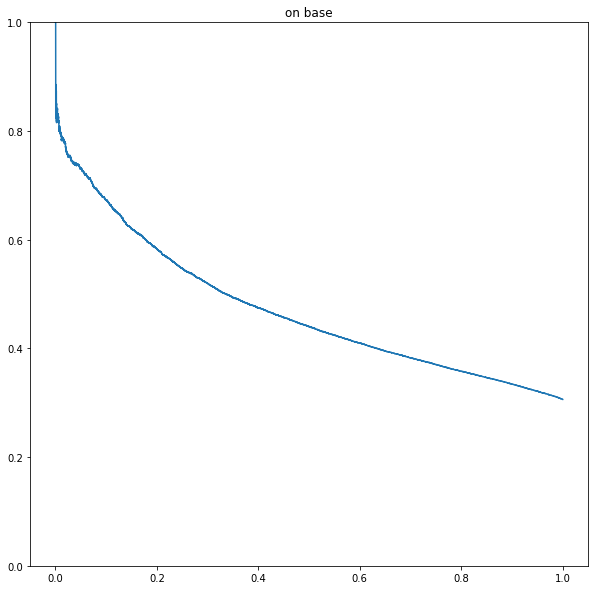

In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

preds = linear_model.predict(X_t.values)
p, r, t = precision_recall_curve(y, preds)
ax.plot(r, p)
ax.set_ylim([0, 1])
_ = ax.set_title('on base')

# Getting deeper

## Define an encoder

To map IDs to valid range for `keras` embedding layers

In [55]:
from sklearn.base import TransformerMixin

class Encoder(TransformerMixin):
    def __init__(self):
        self.mappings = {}

    def fit(self, X):
        self.mappings = {
            feature: {v: i for i, v in enumerate(X[feature].unique())}
            for feature in X.columns
        }
        return self
    
    def transform(self, X):
        return {
            f'{feature}_input': X[feature].map(self.mappings[feature]).values
            for feature in X.columns
            if feature in self.mappings
        }

    def inverse_transform(self, X, feature):
        return X.map({v: k for k, v in self.mappings[feature].items()})
    
    def get_feature_dim(self, feature):
        return len(self.mappings[feature])

## Build batches for training

In [56]:
encoder = Encoder()
encoder.fit(df[categorical_features])

In [57]:
if False:
    sample_key = df[['game_pk', 'at_bat_number']].apply(lambda x: hash(tuple(x)) % 100, axis=1)
    df_sample = df[sample_key <= 10]
else:
    df_sample = df

In [58]:
df_sample.shape

(566962, 106)

Here we "featurize" each at-bat. In the following step we sort each at-bat by the number of pitches thrown and build the batches based on these groups so that we minimize padding during training.

In [59]:
from tqdm import tqdm_notebook as tqdm

df_sample.sort_values(['game_pk', 'at_bat_number', 'pitch_number'], inplace=True)

groups = df_sample.groupby([
    'game_pk', 'at_bat_number'
], as_index=False)
groups = list(groups)
np.random.shuffle(groups)
groups = tqdm(groups)

X_train = []
y_train = []

def featurize_at_bat(group_df):
    x = encoder.transform(group_df[categorical_features])
    x['numeric_inputs'] = group_df[numeric_features].values
    
    assert len(group_df.target.unique()) <= 2
    y = group_df.target.max().astype(int)

    y_aux = np.stack(group_df['auxillary_targets'])
    return x, y, y_aux, len(x['numeric_inputs'])

In [60]:
import multiprocessing as mp
import numpy as np

# this takes ridiculously long if not parallelized
pool = mp.Pool(2 * mp.cpu_count())
res = pool.imap_unordered(featurize_at_bat, (df for _, df in groups))
res = sorted(res, key=lambda x: x[-1])
X_train, y_train, y_aux_train, batch_lens = zip(*res)

In [61]:
len(X_train), len(y_train), len(y_aux_train)

(144994, 144994, 144994)

## Create a list of the batches

In [62]:
import numpy as np

# assign each at-bat an ID so that each batch
# has roughly 32 at-bats
batch_ids = np.cumsum(batch_lens) // (4 * 32)
len(batch_ids), len(set(batch_ids))

(144994, 4430)

In [63]:
batch_ids[:1000:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])

In [64]:
from itertools import groupby
i = iter(batch_ids)
gb = groupby(zip(X_train, y_train, y_aux_train), key=lambda x: next(i))

In [65]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences

input_features = [
    f'{f}_input' for f in categorical_features
] + ['numeric_inputs']

def batch_generator(gb):
    for batch_id, batch in gb:
        xs, ys, ys_aux = zip(*list(batch))
        X_batch = {}
        for f in input_features:
            X_batch[f] = pad_sequences([x[f] for x in xs])
        y = np.array(ys)
        y_aux = np.array(ys_aux)
        yield X_batch, y, y_aux
        

In [66]:
i = iter(batch_ids)
gb = groupby(zip(X_train, y_train, y_aux_train), key=lambda x: next(i))
batches = list(batch_generator(gb))

In [67]:
len(batches)

4430

In [68]:
batches[0][0]['numeric_inputs'].shape, batches[0][1].shape, batches[0][2].shape

((127, 1, 24), (127,), (127, 1, 3))

In [69]:
batches[-1][0]['numeric_inputs'].shape, batches[-1][1].shape, batches[-1][2].shape

((3, 21, 24), (3,), (3,))

In [70]:
i_range = iter(range(len(batches)))

In [71]:
i = next(i_range)
batches[i][0]['numeric_inputs'].shape, batches[i][1].shape, batches[i][2].shape

((127, 1, 24), (127,), (127, 1, 3))

# Hybrid model

In [72]:
import keras
import keras.backend as K


Sum = keras.layers.Lambda(lambda x: K.sum(x, axis=1))
def Attention(X):
    # https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf
    W = keras.layers.Dense(K.int_shape(X)[-1], activation='tanh', name='W')
    u = W(X)
    u_w = keras.layers.Dense(1, activation='linear', name='u_w')
    attention = keras.layers.Softmax(1)(u_w(u))
    X_attended = keras.layers.Multiply()([X, attention])
    return Sum(X_attended), attention


categorical_dimmensions = {
    'batter_id': 1,
    'pitcher_id': 1,
}

numeric_input = keras.layers.Input((None, len(numeric_features),), name='numeric_inputs')
X_numeric_input = keras.layers.BatchNormalization()(numeric_input)

categorical_inputs = []
embeddings = {}
for feature in categorical_features:
    input_ = keras.layers.Input((None,), name=f'{feature}_input')
    output_dim = categorical_dimmensions.get(feature, 1)
    embedding =  keras.layers.Embedding(input_dim=encoder.get_feature_dim(feature) + 1,
                                        output_dim=output_dim,
                                        name=f'{feature}_embedding')(input_)
    categorical_inputs.append(input_)
    embeddings[feature] = embedding

# Average is just a hacky way to get these embeddings 2D.
Avg = keras.layers.Lambda(lambda x: K.mean(x, axis=1))
batter_embedding = Avg(embeddings.pop('batter_id'))
pitcher_embedding = Avg(embeddings.pop('pitcher_id'))
X_embeddings = keras.layers.Concatenate(axis=-1)(list(embeddings.values()))

X = keras.layers.Concatenate()([X_numeric_input, X_embeddings])
X = keras.layers.BatchNormalization()(X)
X_lstm = keras.layers.Bidirectional(
    keras.layers.LSTM(32, dropout=0.1, recurrent_dropout=0.1, return_sequences=True),
    merge_mode='sum')(X)
X, attention = Attention(X_lstm)
X = keras.layers.Concatenate()([
    X,
    pitcher_embedding,
    batter_embedding
])
X = keras.layers.Dense(1, activation='sigmoid', name='y')(X)

hybrid_model = keras.models.Model(
    inputs=[numeric_input] + list(categorical_inputs),
    outputs=X)

In [73]:
hybrid_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
if_fielding_alignment_input (In (None, None)         0                                            
__________________________________________________________________________________________________
of_fielding_alignment_input (In (None, None)         0                                            
__________________________________________________________________________________________________
inning_topbot_input (InputLayer (None, None)         0                                            
__________________________________________________________________________________________________
pitch_name_input (InputLayer)   (None, None)         0                                            
__________________________________________________________________________________________________
zone_input

In [74]:
hybrid_model.compile(loss='binary_crossentropy', optimizer='adam')

In [75]:
L = []
def g():
    while True:
        np.random.shuffle(batches)
        for X, y, y_aux in batches:
            if len(y_aux.shape) != 3:
                L.append(None)
                continue
            yield X, y
hybrid_model.fit_generator(g(), steps_per_epoch=len(batches), epochs=5)

Epoch 1/5
4430/4430 [==============================] - 40s 9ms/step - loss: 0.5570
Epoch 2/5
4430/4430 [==============================] - 38s 9ms/step - loss: 0.5278
Epoch 3/5
4430/4430 [==============================] - 38s 9ms/step - loss: 0.5192
Epoch 4/5
4430/4430 [==============================] - 38s 9ms/step - loss: 0.5144
Epoch 5/5
4430/4430 [==============================] - 38s 9ms/step - loss: 0.5110


In [76]:
len(L)

70

## P/R curves

In [77]:
preds = np.concatenate([hybrid_model.predict(x) for x, _, _ in batches])
y_all = np.concatenate([y for _, y, _ in batches])

In [78]:
y_all.mean(axis=0)

0.30497813702635973

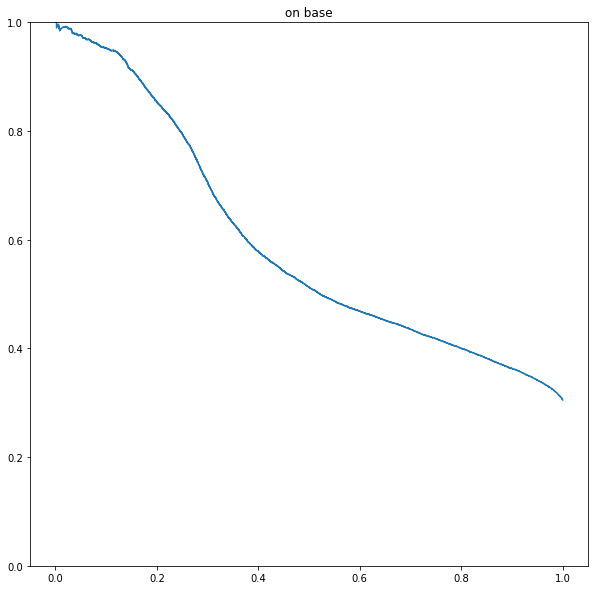

In [79]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

p, r, t = precision_recall_curve(y_all, preds)
ax.plot(r, p)
ax.set_ylim([0, 1])
_ = ax.set_title('on base')

## Defining utility functions

In [80]:
def get_feature_embeddings(X, feature, model):
    input_ = encoder.transform(X)[f'{feature}_input']
    return get_embeddings(input_, model, feature)

def get_embeddings(X, model, feature):
    input_ = model.get_layer(f'{feature}_input').get_output_at(-1)
    encoding = model.get_layer(f'{feature}_embedding').get_output_at(-1)
    return keras.models.Model(inputs=input_, outputs=encoding).predict(X)

## Look at embeddings

In [81]:
hybrid_model.get_layer('y').get_weights()[0][-1]

array([-0.9607815], dtype=float32)

In [82]:
batters = df[['batter_id', 'batter_mlbname']].drop_duplicates()
batters = batters.merge(stats, left_on='batter_id', right_on='batter_mlbid')
batters = batters[batters.AB > 100]
batter_embeddings = get_feature_embeddings(batters, 'batter_id', hybrid_model).reshape(-1)
batter_coefs = hybrid_model.get_layer('y').get_weights()[0][-1]
batters['prob_on_base'] = batter_embeddings * batter_coefs
batters.sort_values('prob_on_base', ascending=False).head(10)

,batter_id,batter_mlbname,batter_mlbid,H,BB,HBP,2B,3B,HR,SF,AB,1B,ba,obp,slg,ops,prob_on_base
381,643446.0,Jeff McNeil,643446.0,74,14,5.0,11,6,3,0.0,225,72,0.328889,0.381148,0.551111,0.932259,0.383580
0,605141.0,Mookie Betts,605141.0,180,81,8.0,47,5,32,5.0,520,170,0.346154,0.438111,0.782692,1.220803,0.363797
92,514888.0,Jose Altuve,514888.0,169,55,6.0,29,2,13,1.0,534,155,0.316479,0.385906,0.507491,0.893397,0.313086
125,456715.0,Lorenzo Cain,456715.0,166,71,8.0,25,2,10,2.0,539,153,0.307978,0.395161,0.461967,0.857128,0.302133
59,516416.0,Jean Segura,516416.0,178,32,4.0,29,3,10,6.0,586,162,0.303754,0.340764,0.459044,0.799809,0.291237
109,545361.0,Mike Trout,545361.0,147,122,10.0,24,4,39,4.0,471,166,0.312102,0.459638,0.811040,1.270678,0.288884
397,572228.0,Luke Voit,572228.0,46,17,1.0,5,0,15,0.0,143,56,0.321678,0.397516,0.881119,1.278634,0.288377
190,518692.0,Freddie Freeman,518692.0,191,76,7.0,44,4,23,6.0,618,174,0.309061,0.387553,0.592233,0.979786,0.282955
387,665742.0,Juan Soto,665742.0,121,79,0.0,25,1,22,0.0,414,119,0.292271,0.405680,0.628019,1.033699,0.282637
257,594809.0,Adam Eaton,594809.0,96,38,11.0,18,1,5,0.0,319,84,0.300940,0.394022,0.448276,0.842298,0.277013


In [83]:
batters.to_csv('deep-learning-static/hybrid-batter-coefficients.csv', index=False)

In [84]:
hybrid_model.get_layer('y').get_weights()[0][-2]

array([-0.8739643], dtype=float32)

In [85]:
pitchers = df[['pitcher_id', 'player_name']].drop_duplicates()
pitchers = pitchers.merge(pitching_stats, left_on='pitcher_id', right_on='pitcher_mlbid')
pitcher_embeddings = get_feature_embeddings(pitchers, 'pitcher_id', hybrid_model).reshape(-1)
pitcher_coefs = hybrid_model.get_layer('y').get_weights()[0][-2]
pitchers['prob_not_on_base'] = pitcher_embeddings * pitcher_coefs
pitchers[pitchers.IP > 100].sort_values('prob_not_on_base', ascending=True).head(10)

,pitcher_id,player_name,pitcher_mlbid,IP,BB,H,ER,ERA,WHIP,prob_not_on_base
320,621111.0,Walker Buehler,621111.0,137.333333,37,95,40,2.621359,0.961165,-0.374267
129,605483.0,Blake Snell,605483.0,180.666667,64,112,38,1.892989,0.974170,-0.357984
230,594798.0,Jacob deGrom,594798.0,217.000000,46,152,41,1.700461,0.912442,-0.348614
399,605397.0,Joe Musgrove,605397.0,115.333333,23,113,52,4.057803,1.179191,-0.339582
294,656794.0,Sean Newcomb,656794.0,164.000000,81,137,71,3.896341,1.329268,-0.324976
130,456034.0,David Price,456034.0,176.000000,50,151,70,3.579545,1.142045,-0.309912
26,446372.0,Corey Kluber,446372.0,215.000000,34,179,69,2.888372,0.990698,-0.303270
122,453286.0,Max Scherzer,453286.0,220.666667,51,150,62,2.528701,0.910876,-0.288880
249,501985.0,Mike Minor,501985.0,157.000000,38,138,73,4.184713,1.121019,-0.242792
307,518774.0,Matt Harvey,518774.0,155.000000,37,165,85,4.935484,1.303226,-0.230416


In [86]:
pitchers[pitchers.IP < 100].sort_values('prob_not_on_base', ascending=True).head(10)

,pitcher_id,player_name,pitcher_mlbid,IP,BB,H,ER,ERA,WHIP,prob_not_on_base
197,451584.0,Wade Davis,451584.0,65.333333,26,43,30,4.132653,1.056122,-0.621182
42,600917.0,Jose Leclerc,600917.0,57.666667,25,24,10,1.560694,0.849711,-0.486856
345,543507.0,Trevor May,543507.0,25.333333,5,21,9,3.197368,1.026316,-0.468916
11,467008.0,Pedro Strop,467008.0,59.666667,21,38,15,2.262570,0.988827,-0.463308
299,456696.0,David Hernandez,456696.0,64.000000,17,46,18,2.531250,0.984375,-0.438478
38,493603.0,Adam Ottavino,493603.0,77.666667,36,41,21,2.433476,0.991416,-0.431585
128,448281.0,Sean Doolittle,448281.0,45.000000,6,21,8,1.600000,0.600000,-0.430733
59,623352.0,Josh Hader,623352.0,81.333333,30,36,22,2.434426,0.811475,-0.411428
372,592468.0,Nick Kingham,592468.0,76.000000,26,79,44,5.210526,1.381579,-0.409978
85,547973.0,Aroldis Chapman,547973.0,51.333333,30,24,14,2.454545,1.051948,-0.391822


In [87]:
pitchers.to_csv('deep-learning-static/hybrid-pitcher-coefficients.csv', index=False)

# Recurrent model

In [88]:
import keras
import keras.backend as K

# LSTM input
Sum = keras.layers.Lambda(lambda x: K.sum(x, axis=1))
def Attention(X):
    # https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf
    W = keras.layers.Dense(K.int_shape(X)[-1], activation='tanh', name='W')
    u = W(X)
    u_w = keras.layers.Dense(1, activation='linear', name='u_w')
    attention = keras.layers.Softmax(1)(u_w(u))
    X_attended = keras.layers.Multiply()([X, attention])
    return Sum(X_attended), attention


categorical_dimmensions = {
    'batter_id': 2,
    'pitcher_id': 2,
}

numeric_input = keras.layers.Input((None, len(numeric_features),), name='numeric_inputs')
X_numeric_input = keras.layers.BatchNormalization()(numeric_input)

categorical_inputs = []
embeddings = {}
for feature in categorical_features:
    input_ = keras.layers.Input((None,), name=f'{feature}_input')
    output_dim = categorical_dimmensions.get(feature, 1)
    embedding =  keras.layers.Embedding(input_dim=encoder.get_feature_dim(feature) + 1,
                                        output_dim=output_dim,
                                        name=f'{feature}_embedding')(input_)
    categorical_inputs.append(input_)
    embeddings[feature] = embedding

X_embeddings = keras.layers.Concatenate(axis=-1)(list(embeddings.values()))
X = keras.layers.Concatenate()([X_numeric_input, X_embeddings])
X = keras.layers.BatchNormalization()(X)
X_lstm = keras.layers.LSTM(32, dropout=0.1, recurrent_dropout=0.1, return_sequences=True)(X)
# X_lstm = keras.layers.Bidirectional(
#     keras.layers.LSTM(32, dropout=0.1, recurrent_dropout=0.1, return_sequences=True),
#     merge_mode='sum')(X)
X, attention = Attention(X_lstm)

# X = keras.layers.Dense(32, activation='relu')(X)
# X = keras.layers.BatchNormalization()(X)
X = keras.layers.Dense(1, activation='sigmoid', name='y')(X)

X_aux = keras.layers.Dense(32, activation='relu')(X_lstm)
X_aux = keras.layers.BatchNormalization()(X_aux)
X_aux = keras.layers.Dense(len(auxillary_targets), name='y_aux')(X_aux)

nonlinear_model = keras.models.Model(
    inputs=[numeric_input] + list(categorical_inputs),
    outputs=[X, X_aux])

In [89]:
nonlinear_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
if_fielding_alignment_input (In (None, None)         0                                            
__________________________________________________________________________________________________
of_fielding_alignment_input (In (None, None)         0                                            
__________________________________________________________________________________________________
inning_topbot_input (InputLayer (None, None)         0                                            
__________________________________________________________________________________________________
pitch_name_input (InputLayer)   (None, None)         0                                            
__________________________________________________________________________________________________
zone_input

In [90]:
nonlinear_model.compile(loss={'y': 'binary_crossentropy', 'y_aux': 'mse'}, optimizer='adam')

In [91]:
L = []
def g():
    while True:
        np.random.shuffle(batches)
        for X, y, y_aux in batches:
            if len(y_aux.shape) != 3:
                L.append(None)
                continue
            # (X, y, sample_weights)
            yield X, {'y': y, 'y_aux': y_aux}, {'y_aux': np.where(y, 1., 0.05)}
nonlinear_model.fit_generator(g(), steps_per_epoch=len(batches), epochs=5)

Epoch 1/5
4430/4430 [==============================] - 41s 9ms/step - loss: 0.6624 - y_loss: 0.5679 - y_aux_loss: 0.0945
Epoch 2/5
4430/4430 [==============================] - 39s 9ms/step - loss: 0.6151 - y_loss: 0.5325 - y_aux_loss: 0.0826
Epoch 3/5
4430/4430 [==============================] - 40s 9ms/step - loss: 0.6033 - y_loss: 0.5220 - y_aux_loss: 0.0813
Epoch 4/5
4430/4430 [==============================] - 39s 9ms/step - loss: 0.5964 - y_loss: 0.5157 - y_aux_loss: 0.0807
Epoch 5/5
4430/4430 [==============================] - 40s 9ms/step - loss: 0.5931 - y_loss: 0.5127 - y_aux_loss: 0.0803


In [92]:
len(L)

70

## P/R curves

In [93]:
preds = np.concatenate([nonlinear_model.predict(x)[0] for x, _, _ in batches])
y_all = np.concatenate([y for _, y, _ in batches])

In [94]:
y_all.mean(axis=0)

0.30497813702635973

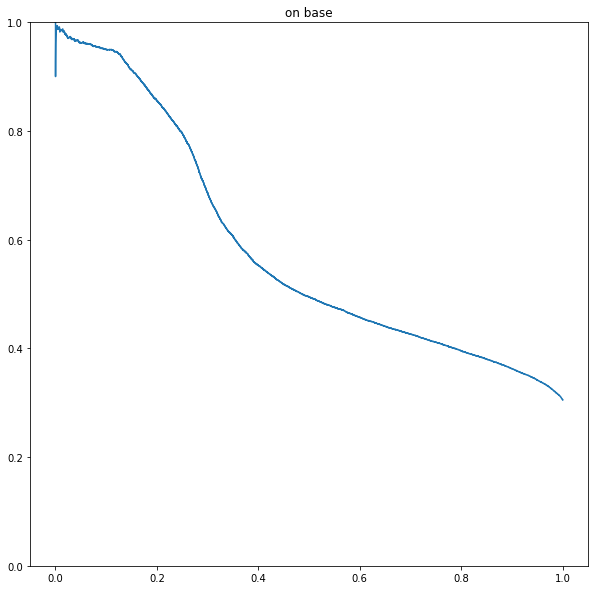

In [95]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

p, r, t = precision_recall_curve(y_all, preds)
ax.plot(r, p)
ax.set_ylim([0, 1])
_ = ax.set_title('on base')

# Inspect model

## Pitcher embeddings

In [96]:
pitchers = df[['pitcher_id', 'player_name']].drop_duplicates()
pitchers = pitching_stats.merge(pitchers, left_on='pitcher_mlbid', right_on='pitcher_id')
pitcher_embeddings = get_feature_embeddings(pitchers, 'pitcher_id', nonlinear_model)
pitchers['x'], pitchers['y'] = zip(*pitcher_embeddings.reshape((-1, 2)))

In [97]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, LinearColorMapper, ColorBar
from bokeh.io import output_notebook
from bokeh.transform import transform

output_notebook()

lookat =  'WHIP'

idx = np.ones_like(pitchers.index).astype(bool)
source = ColumnDataSource(
        data=dict(
            x=pitchers[idx].x,
            y=pitchers[idx].y,
            desc=pitchers[idx].player_name,
            WHIP=pitchers[idx].WHIP
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap'],
           title="Pitcher embeddings shaded by WHIP")

from bokeh.palettes import Viridis3, Viridis256

transformer = LinearColorMapper(
    palette=Viridis256[::-1], low=pitchers[lookat].min(), high=pitchers[lookat].max())
p.circle('x', 'y', size=10, source=source, fill_color={'field': lookat, 'transform': transformer})
color_bar = ColorBar(color_mapper=transformer, location=(0, 0))
p.add_layout(color_bar, 'right')
output_file('deep-learning-static/pitcher-embeddings.html', title='Pitcher Embeddings', mode='inline')
show(p)

Loading BokehJS ...

## Look at batter embeddings

In [98]:
# from sklearn.manifold import TSNE
batters = df[['batter_id', 'batter_mlbname']].drop_duplicates()
batters = batters.merge(stats, left_on='batter_id', right_on='batter_mlbid')
batters = batters[batters.AB > 100]
batter_embeddings = get_feature_embeddings(batters, 'batter_id', nonlinear_model)
# batters['x'], batters['y'] = zip(*TSNE(2).fit_transform(batter_embeddings.reshape((-1, 4))))
batters['x'], batters['y'] = zip(*batter_embeddings.reshape((-1, 2)))

In [99]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, LinearColorMapper, ColorBar
from bokeh.io import output_notebook
from bokeh.transform import transform
output_notebook()


lookat = 'slg'

source = ColumnDataSource(
        data=dict(
            x=batters.x,
            y=batters.y,
            desc=batters.batter_mlbname,
            slg=batters.slg,
            obp=batters.obp,
            ops=batters.ops,
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap', 'wheel_zoom', 'box_zoom'],
           title="Batter embeddings shaded by SLG")

from bokeh.palettes import Viridis3, Viridis256

transformer = LinearColorMapper(
    palette=Viridis256, low=batters[lookat].min(), high=batters[lookat].max())
p.circle('x', 'y', size=10, source=source, fill_color={'field': lookat, 'transform': transformer})
color_bar = ColorBar(color_mapper=transformer, location=(0, 0))
p.add_layout(color_bar, 'right')
output_file('deep-learning-static/batter-embeddings-slg.html', title='Batter Embeddings By SLG', mode='inline')
show(p)


Loading BokehJS ...

In [100]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, LinearColorMapper, ColorBar
from bokeh.io import output_notebook
from bokeh.transform import transform
output_notebook()


lookat = 'ops'

source = ColumnDataSource(
        data=dict(
            x=batters.x,
            y=batters.y,
            desc=batters.batter_mlbname,
            slg=batters.slg,
            obp=batters.obp,
            ops=batters.ops,
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap', 'wheel_zoom', 'box_zoom'],
           title="Batter embeddings shaded by OPS")

from bokeh.palettes import Viridis3, Viridis256

transformer = LinearColorMapper(
    palette=Viridis256, low=batters[lookat].min(), high=batters[lookat].max())
p.circle('x', 'y', size=10, source=source, fill_color={'field': lookat, 'transform': transformer})
color_bar = ColorBar(color_mapper=transformer, location=(0, 0))
p.add_layout(color_bar, 'right')
output_file('deep-learning-static/batter-embeddings-ops.html', title='Batter embeddings Embeddings by OPS', mode='inline')
show(p)


Loading BokehJS ...

## Look at attention

In [101]:
attention_model = keras.models.Model(inputs=[numeric_input] + list(categorical_inputs), outputs=attention)

In [102]:
examples = [
    # Segura walks, model "pays attention" to balls
    (530611.0, 39.0),
    # mookie homers
    (530718.0, 1.0),
    # J. T. grounds out
    (531625.0, 61.0),
]

In [107]:
c = [
    'des',
    'attention',
    'pitch_name',
    'zone',
    'balls',
    'strikes',
    'total_pitch_number',
    'fld_score',
    'bat_score'
]

for game_pk, at_bat_number in examples:
    atbat = df[df.game_pk.eq(game_pk) & df.at_bat_number.eq(at_bat_number)].copy()

    xx = featurize_at_bat(atbat)[0]
    xx = {k: np.expand_dims(v, axis=0) for k, v in xx.items()}
    pp = nonlinear_model.predict(xx)[0][0]
    aa = attention_model.predict(xx)

    atbat['attention'] = aa.reshape(-1)
    print('predicted on base with probability:', pp)
    print(atbat.iloc[-1].des)
    with pd.option_context('display.max_columns', None):
        display(atbat[c])
        atbat[c].to_csv(f'deep-learning-static/{atbat.iloc[-1].des}.csv', index=False)

predicted on base with probability: [0.78716576]
Jean Segura walks.  


,des,attention,pitch_name,zone,balls,strikes,total_pitch_number,fld_score,bat_score
311570,NaN,0.000008,Split Finger,7.0,0.0,0.0,65,4.0,2.0
311569,NaN,0.000004,Knuckle Curve,14.0,0.0,1.0,66,4.0,2.0
311568,NaN,0.000011,4-Seam Fastball,2.0,1.0,1.0,67,4.0,2.0
311567,NaN,0.000017,4-Seam Fastball,12.0,1.0,2.0,68,4.0,2.0
311566,NaN,0.000235,Split Finger,14.0,2.0,2.0,69,4.0,2.0
311565,NaN,0.073793,4-Seam Fastball,6.0,3.0,2.0,70,4.0,2.0
311564,Jean Segura walks.,0.925931,4-Seam Fastball,14.0,3.0,2.0,71,4.0,2.0


predicted on base with probability: [0.45372725]
Mookie Betts homers (22) on a fly ball to left center field.  


,des,attention,pitch_name,zone,balls,strikes,total_pitch_number,fld_score,bat_score
388120,NaN,0.245446,2-Seam Fastball,14.0,0.0,0.0,1,0.0,0.0
388119,NaN,0.293591,2-Seam Fastball,5.0,1.0,0.0,2,0.0,0.0
388118,Mookie Betts homers (22) on a fly ball to left...,0.460964,2-Seam Fastball,2.0,1.0,1.0,3,0.0,0.0


predicted on base with probability: [0.450101]
J.  T.   Realmuto grounds out, shortstop Asdrubal Cabrera to first baseman Rhys Hoskins.  


,des,attention,pitch_name,zone,balls,strikes,total_pitch_number,fld_score,bat_score
494247,NaN,0.044510,Cutter,3.0,0.0,0.0,1,5.0,4.0
494246,NaN,0.027510,2-Seam Fastball,14.0,0.0,1.0,2,5.0,4.0
494245,NaN,0.056896,Cutter,14.0,1.0,1.0,3,5.0,4.0
494244,"J. T. Realmuto grounds out, shortstop Asdru...",0.871084,2-Seam Fastball,5.0,2.0,1.0,4,5.0,4.0


# Probing the model

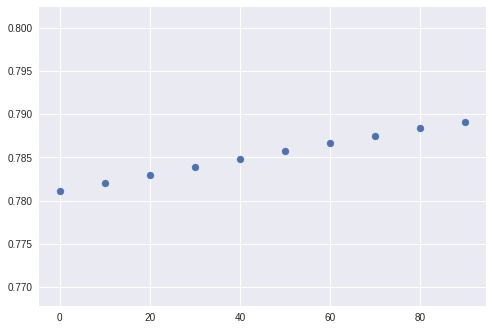

In [108]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
atbat = df[df.game_pk.eq(examples[0][0]) & df.at_bat_number.eq(examples[0][1])].copy()
predictions = []
probe = np.arange(0, 10) * 10
for total_pitch_number_begin in probe:
    atbat['total_pitch_number'] = atbat.total_pitch_number - atbat.total_pitch_number.min() + total_pitch_number_begin
    atbat['inning'] = total_pitch_number_begin // 15
    xx = featurize_at_bat(atbat)[0]
    xx = {k: np.expand_dims(v, axis=0) for k, v in xx.items()}
    predictions.append(nonlinear_model.predict(xx)[0][0])
plt.scatter(probe, predictions)
plt.savefig('deep-learning-static/probing-model-pitch-number-segura-walks.png')